In [1]:
import segmentation_models_pytorch as smp
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from torch.fx.experimental.meta_tracer import torch_abs_override
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import albumentations as Album
import torch.nn.functional as Functional
import pandas as pd
import nibabel as nib
from torchvision.transforms.v2.functional import center_crop
from tqdm import tqdm
# from google.colab import drive

C:\Users\sammi\anaconda3\envs\tensorflow-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
! pip show albumentations

Name: albumentations
Version: 1.1.0
Summary: Fast image augmentation library and easy to use wrapper around other libraries
Home-page: https://github.com/albumentations-team/albumentations
Author: Buslaev Alexander, Alexander Parinov, Vladimir Iglovikov, Eugene Khvedchenya, Druzhinin Mikhail
Author-email: 
License: MIT
Location: c:\users\sammi\anaconda3\envs\tensorflow-env\lib\site-packages
Requires: numpy, opencv-python-headless, PyYAML, qudida, scikit-image, scipy
Required-by: 


In [3]:
# PATHS MIGHT CHANGE FOR COLAB
training_df = pd.read_csv('../data/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv')
root_df = '../data/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

In [4]:
training_df.head(10)

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,BraTS_2020_subject_ID
0,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1,BraTS20_Training_001
1,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1,BraTS20_Training_002
2,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1,BraTS20_Training_003
3,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1,BraTS20_Training_004
4,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1,BraTS20_Training_005
5,HGG,Brats17_CBICA_ABE_1,Brats18_CBICA_ABE_1,NaN,BraTS19_CBICA_ABE_1,BraTS20_Training_006
6,HGG,Brats17_CBICA_ABM_1,Brats18_CBICA_ABM_1,NaN,BraTS19_CBICA_ABM_1,BraTS20_Training_007
7,HGG,Brats17_CBICA_ABN_1,Brats18_CBICA_ABN_1,NaN,BraTS19_CBICA_ABN_1,BraTS20_Training_008
8,HGG,Brats17_CBICA_ABO_1,Brats18_CBICA_ABO_1,NaN,BraTS19_CBICA_ABO_1,BraTS20_Training_009
9,HGG,Brats17_CBICA_ABY_1,Brats18_CBICA_ABY_1,NaN,BraTS19_CBICA_ABY_1,BraTS20_Training_010


Exporting CSV Files to be used as reference for MRI Imaging files (.nii) to their respective file paths

In [5]:
root_list = []
tot_list = []

for filename_root in tqdm(np.sort(os.listdir(root_df))[:-2]):
    subpath = os.path.join(root_df, filename_root)
    file_list = []

    for filename in np.sort(os.listdir(subpath)):
        file_list.append(os.path.join(subpath, filename))

    root_list.append(filename_root)
    tot_list.append(file_list)
 
maps = pd.concat([
    pd.DataFrame(root_list, columns=['DIR']),
    pd.DataFrame(tot_list, columns=['flair', 'seg', 't1', 't1ce', 't2']) 
    
], axis=1)

maps.to_csv('links.csv', index=False)

100%|██████████| 369/369 [00:00<00:00, 17496.22it/s]


In [6]:
image_path = {
    'seg': [],
    't1': [],
    't1ce': [],
    't2': [],
    'flair': []
}

for path in training_df['BraTS_2020_subject_ID']:
    patient = os.path.join(root_df, path)

    for name in image_path:
        image_path[name].append(os.path.join(patient, path + f'_{name}.nii'))

image_path['seg'][:5]

['../data/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\\BraTS20_Training_001\\BraTS20_Training_001_seg.nii',
 '../data/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\\BraTS20_Training_002\\BraTS20_Training_002_seg.nii',
 '../data/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\\BraTS20_Training_003\\BraTS20_Training_003_seg.nii',
 '../data/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\\BraTS20_Training_004\\BraTS20_Training_004_seg.nii',
 '../data/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\\BraTS20_Training_005\\BraTS20_Training_005_seg.nii']

In [7]:
def load_image(image_path):
    return nib.load(image_path).get_fdata()
    # return nib.load(image_path).get_filename()


def centre_crop(image_slice, crop_x, crop_y):
    # function to crop from the center
    
    # Provided arguments for cropping may be larger than the original image... resulting in unusual image cropping
    # The first line obtains width and height from the original image
    # The last two lines choose the maximum dimension without exceeding the limits of the original image dimensions
    
    y, x = image_slice.shape

    start_x = x // 2 - (crop_x // 2)
    start_y = y // 2 - (crop_y // 2)

    return image_slice[start_y : start_y + crop_y, start_x : start_x + crop_x]

def normalize(image_slice):
    # The use of a StandardScaler for normalization
    # The idea behind it is to transform the data so the distribution should end up with a mean of 0 and a standard deviation of 1.
    # In other cases like having multivariate data, it will be done independently for each column of the data
    # Hence, provided the data distribution, each value in the dataset will have their mean values subtracted and the divided by the standard deviation value of the entire dataset,
    # or feature in other cases such as multivariate data
    
    return (image_slice - image_slice.mean()) / image_slice.std()

In [8]:
def create_dataset_directories(base_dir="dataset"):
    os.makedirs(os.path.join(base_dir, "t1"), exist_ok=True)
    os.makedirs(os.path.join(base_dir, "t1ce"), exist_ok=True)
    os.makedirs(os.path.join(base_dir, "t2"), exist_ok=True)
    os.makedirs(os.path.join(base_dir, "flair"), exist_ok=True)
    os.makedirs(os.path.join(base_dir, "seg"), exist_ok=True)

In [9]:
create_dataset_directories('../dataset')
# Save the stress because the directory already exists

In [10]:
images_saved = 0
imgs = {}
image_slice = {}

save_limit = 5000 # due to retention on the cpu

for i in (range(len(image_path['seg']))):
    
    for name in image_path:
        imgs[name] = load_image(image_path[name][i])

    for j in range(155):
        for name in imgs:
            image_slice[name] = imgs[name][:, :, j]
            image_slice[name] = centre_crop(image_slice[name], 128, 128)

        if image_slice['seg'].max() > 0:
            for name in ['t1', 't2', 't1ce', 'flair']:
                image_slice[name] = normalize(image_slice[name])

            for name in image_slice:
                np.save(f'../dataset/{name}/image_{images_saved}.npy', image_slice[name])

            images_saved += 1

        if images_saved == save_limit:
            break

    if images_saved == save_limit:
        break

In [11]:
# SOME BASIC IMAGE VISUALIZATIONS

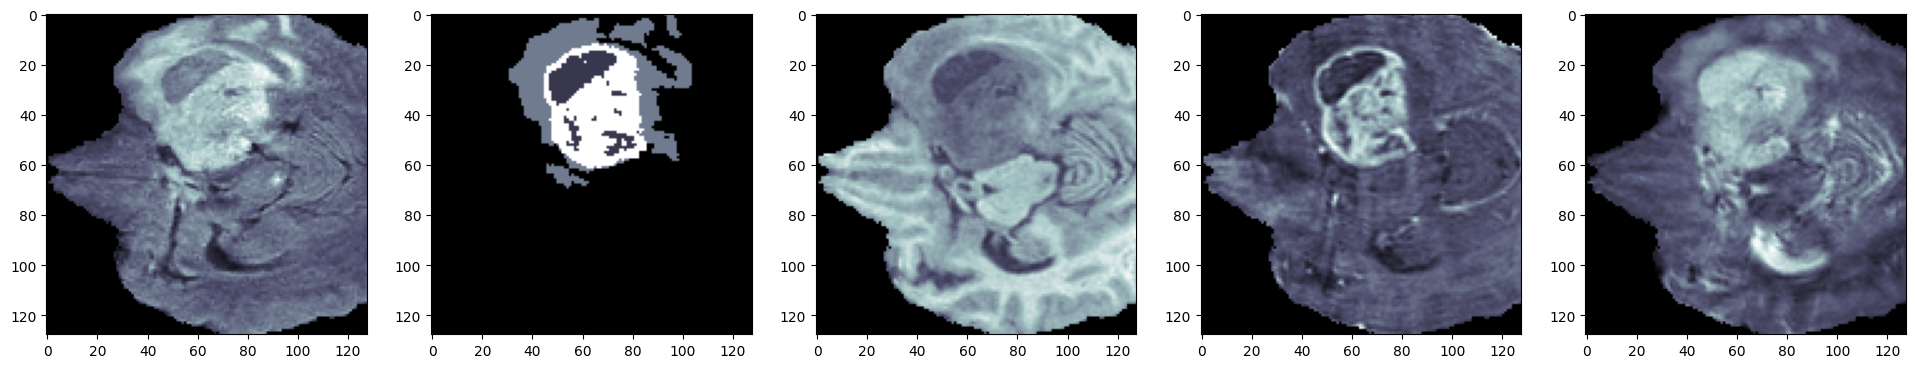

In [13]:
fig = plt.figure(figsize = (24, 15))

image_keys_bw = {
    'flair': 1,
    'seg': 2,
    't1': 3,
    't1ce': 4,
    't2': 5,
}

for key, value in image_keys_bw.items():
    plt.subplot(1, 5, value)
    plt.imshow(np.load(f'../dataset/{key}/image_25.npy'), cmap='bone')
    plt.grid(False)

In [13]:
# WITH SOME COLOUR...

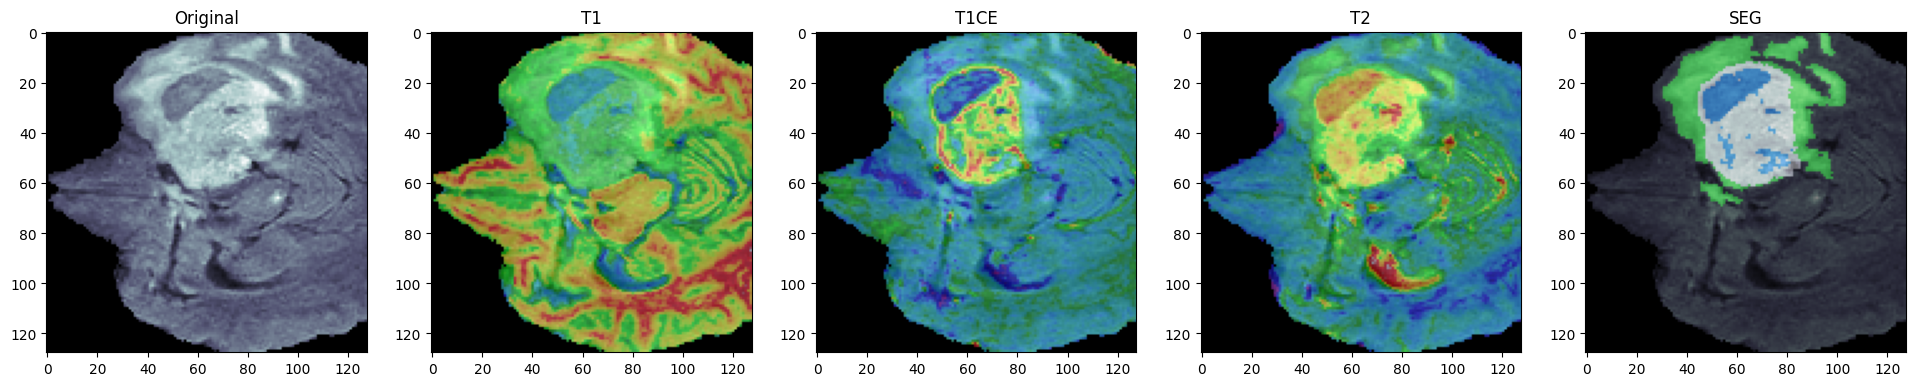

In [14]:
fig = plt.figure(figsize = (24, 15))

image_keys = {
    't1': 2,
    't1ce': 3,
    't2': 4,
    'seg': 5,
}

plt.subplot(1, 5, 1)
plt.imshow(np.load('../dataset/flair/image_25.npy'), cmap ='bone')
plt.grid(False)
plt.title('Original')

for key, value in image_keys.items():
    plt.subplot(1, 5, value)
    plt.imshow(np.load('../dataset/flair/image_25.npy'), cmap ='bone')
    plt.imshow(np.load(f'../dataset/{key}/image_25.npy'), alpha=0.5, cmap='nipy_spectral')
    plt.grid(False)
    plt.title(str(key.upper()))

In [15]:
class DatasetGenerator(Dataset):
    def __init__(self, datapath='dataset/', augmentation=None):
        self.augmentation = augmentation

        self.folderpaths = {
            'mask': os.path.join(datapath, 'seg/'),
            't1': os.path.join(datapath, 't1/'),
            't1ce': os.path.join(datapath, 't1ce/'),
            't2': os.path.join(datapath, 't2/'),
            'flair': os.path.join(datapath, 'flair/'),
        }

    def __getitem__(self, index):
        images = {}

        for name in self.folderpaths:
            images[name] = np.load(os.path.join(self.folderpaths[name], f'image_{index}.npy')).astype(np.float32)

        # print(f"Loaded images for index {index}: {images.keys()}")
 
        if self.augmentation:
            augmented = self.augmentation(
                image=images['flair'],
                mask=images['mask'],
                t1=images['t1'],
                t1ce=images['t1ce'],
                t2=images['t2']
            )
            # print(f"Augmented images for index {index}: {augmented.keys()}")
            images['flair'] = augmented['image']

        for name in images:
            images[name] = torch.from_numpy(images[name])

        # STACKING UP MULTI INPUTS
        input = torch.stack([
            images['t1'],
            images['t1ce'],
            images['t2'],
            images['flair']
            
        ], dim=0)

        images['mask'][images['mask'] == 4] = 3

        # ONE-HOT TRUTH LABEL ENCODING
        images['mask'] = Functional.one_hot(
            images['mask'].long().unsqueeze(0),
            num_classes=4
        ).permute(0, 3, 1, 2).contiguous().squeeze(0)

        return input.float(), images['mask'].long()

    def __len__(self):
        return len(os.listdir(self.folderpaths['mask'])) - 1

In [16]:
augmentation = Album.Compose([
    Album.OneOf([
        Album.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        Album.GridDistortion(p=0.5),
        Album.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5)
        
    ], p=0.8),
    Album.RandomBrightnessContrast(p=0.8)], 
    
    additional_targets={
    't1': 'image',
    't1ce': 'image',
    't2': 'image'
})

valid_test_dataset = DatasetGenerator(datapath='../dataset/', augmentation=None)
train_dataset = DatasetGenerator(datapath='../dataset/', augmentation=augmentation)

# USING A 4:1:1 train-validation-test
train_length = int(0.6 * len(valid_test_dataset))
valid_length = int(0.2 * len(valid_test_dataset))
test_length = len(valid_test_dataset) - train_length - valid_length

_, valid_dataset, test_dataset = torch.utils.data.random_split(
    valid_test_dataset, 
    (train_length, valid_length, test_length), generator=torch.Generator().manual_seed(42)
)

train_dataset, _, _ = torch.utils.data.random_split(
    train_dataset, 
    (train_length, valid_length, test_length), generator=torch.Generator().manual_seed(42)
)

In [17]:
train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=1, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size=1, shuffle=True
)

In [18]:
print(len(train_loader))
print(len(test_loader))
print(len(valid_loader))

188
1001
999


In [19]:
a, b = next(iter(train_loader))

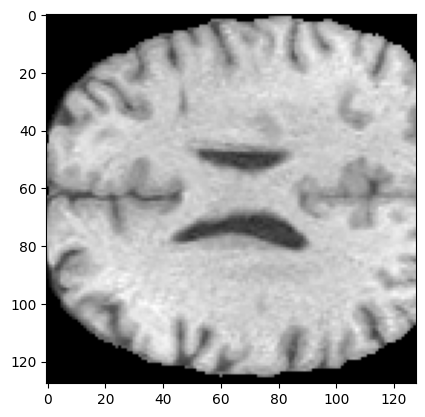

In [20]:
plt.imshow(a[0, 0], cmap='gray')

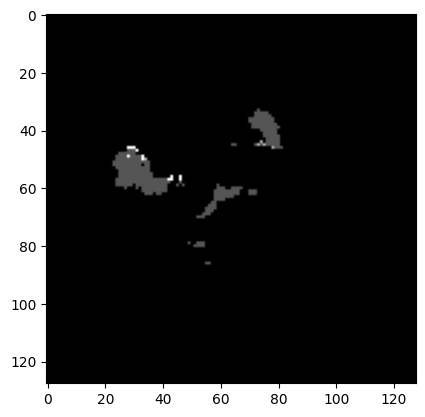

In [21]:
temp = torch.argmax(b, 0)
plt.imshow(temp[0], cmap='gray')

In [22]:
! nvidia-smi

Mon Feb 17 22:04:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.42                 Driver Version: 572.42         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   42C    P8             18W /  200W |    1111MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [23]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(f'* CUDA Device: {torch.cuda.get_device_name("cuda:0")}\n* Device Properties: {torch.cuda.get_device_properties("cuda:0")}')

# device = torch.cuda.device(0)
device = torch.device('cuda:0')

True
* CUDA Device: NVIDIA GeForce RTX 4070
* Device Properties: _CudaDeviceProperties(name='NVIDIA GeForce RTX 4070', major=8, minor=9, total_memory=12281MB, multi_processor_count=46, uuid=f2da3a1e-bdf3-094c-8f5b-f221eb8ef48a, L2_cache_size=36MB)


In [24]:
import torch
import torch.nn as nn

@torch.jit.script
def autocrop(encoder_layer: torch.Tensor, decoder_layer: torch.Tensor):
    if encoder_layer.shape[2:] != decoder_layer.shape[2:]:
        ds = encoder_layer.shape[2:]
        es = decoder_layer.shape[2:]

        assert ds[0] >= es[0]
        assert ds[1] >= es[1]

        # IN CASES OF 2D FORMAT
        if encoder_layer.dim() == 4:
            encoder_layer = encoder_layer[
                :, :, 
                ((ds[0] - es[0]) // 2) : ((ds[0] + es[0]) // 2),
                ((ds[1] - es[1]) // 2) : ((ds[1] + es[1]) // 2)
            ]

        # IN CASES OF 3D FORMATS
        elif encoder_layer.dim() == 5:
            assert ds[2] >= es[2]

            encoder_layer = encoder_layer[
                :, :, 
                ((ds[0] - es[0]) // 2) : ((ds[0] + es[0]) // 2),
                ((ds[1] - es[1]) // 2) : ((ds[1] + es[1]) // 2),
                ((ds[2] - es[2]) // 2) : ((ds[2] + es[2]) // 2)
            ]

        return encoder_layer, decoder_layer
    
    else: 
        return encoder_layer, decoder_layer


def convolution_layer(dim: int):
    if dim == 3: 
        return nn.Conv3d
    elif dim == 2:
        return nn.Conv2d


def get_convolution_layer(
    in_channels: int, out_channels: int,
    kernel_size: int = 3, stride: int = 1,
    padding: int = 1, bias: bool = True, dim: int = 2):

    return convolution_layer(dim)(in_channels, out_channels, kernel_size=kernel_size,
                                 stride=stride, padding=padding, bias=bias)


def convolution_transpose_layer(dim: int):
    if dim == 3:
        return nn.ConvTranspose3d
    elif dim == 2:
        return nn.ConvTranspose2d


def get_up_layer(
    in_channels: int, out_channels: int,
    kernel_size: int = 2, stride: int = 2,
    dim: int = 3, up_mode: str = 'transposed'):

    if up_mode == 'transposed':
        return convolution_transpose_layer(dim)(in_channels, out_channels, 
                                               kernel_size=kernel_size, stride=stride)
    else:
        return nn.Upsample(scale_factor=2.0, mode=up_mode)


def maxpool_layer(dim: int):
    if dim == 3:
        return nn.MaxPool3d
    elif dim == 2:
        return nn.MaxPool2d


def get_maxpool_layer(kernel_size: int = 2, stride: int = 2, padding: int = 0, dim: int = 2):
    return maxpool_layer(dim=dim)(kernel_size=kernel_size, stride=stride, padding=padding)

# LeakyReLU Problem
def get_activation(activation: str):
    if activation == 'relu':
        return nn.ReLU()
    elif activation == 'leaky':
        return nn.LeakyReLU(negative_slope=0.1)
    elif activation == 'elu':
        return nn.ELU()


def get_normalization(normalization: str, num_channels: int, dim: int):
    if normalization == 'batch':
        if dim == 3:
            return nn.BatchNorm3d(num_channels)
        elif dim == 2:
            return nn.BatchNorm2d(num_channels)

    elif normalization == 'instance':
        if dim == 3:
            return nn.InstanceNorm3d(num_channels)
        elif dim == 2:
            return nn.InstanceNorm2d(num_channels)

    elif 'group' in normalization:
        num_groups = int(normalization.partition('group')[-1])
        return nn.GroupNorm(num_groups=num_groups, num_channels=num_channels)


class ConcatenateLayer(nn.Module):
    def __init__(self):
        super(ConcatenateLayer, self).__init__()

    def forward(self, layer_1, layer_2):
        x = torch.cat((layer_1, layer_2), 1)

        return x


class DownBlock(nn.Module):
    def __init__(
            self, 
            in_channels: int,
            out_channels: int, 
            pooling: bool = True,
            activation: str = 'relu',
            normalization: str = None,
            dim: int = 2,
            convolution_mode: str = 'same'):

        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling
        self.normalization = normalization

        if convolution_mode == 'same':
            self.padding = 1
        elif convolution_mode == 'valid':
            self.padding = 0

        self.dim = dim
        self.activation = activation

        # CONVOLUTION LAYERS
        self.convolution1 = get_convolution_layer(
            self.in_channels, self.out_channels, kernel_size=3,
            stride=1, padding=self.padding, bias=True, dim=self.dim
        )
        self.convolution2 = get_convolution_layer(
            self.out_channels, self.out_channels, kernel_size=3,
            stride=1, padding=self.padding, bias=True, dim=self.dim
        )

        # POOLING LAYER
        if self.pooling:
            self.pool = get_maxpool_layer(kernel_size=2, stride=2, padding=0, dim=self.dim)

        # ACTIVATION LAYER
        self.activation1 = get_activation(self.activation)
        self.activation2 = get_activation(self.activation)

        # NORMALIZATION LAYERS
        if self.normalization:
            self.normalization1 = get_normalization(
                normalization=self.normalization, num_channels=self.out_channels,
                dim=self.dim
            )
            self.normalization2 = get_normalization(
                normalization=self.normalization, num_channels=self.out_channels,
                dim=self.dim
            )

    def forward(self, x):
        y = self.convolution1(x)
        y = self.activation1(y)

        if self.normalization:
            y = self.normalization1(y)

        y = self.convolution2(y)
        y = self.activation2(y)

        if self.normalization:
            y = self.normalization2(y)

        before_pooling = y

        if self.pooling:
            y = self.pool(y)

        return y, before_pooling


import torch
import torch.nn as nn

class UpBlock(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 activation: str = 'relu',
                 normalization: str = None,
                 dim: int = 3,
                 convolution_mode: str = 'same',
                 up_mode: str = 'transposed'):

        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalization = normalization

        if convolution_mode == 'same':
            self.padding = 1
        elif convolution_mode == 'valid':
            self.padding = 0

        self.dim = dim
        self.activation = activation
        self.up_mode = up_mode

        # UP-CONVOLUTION/UP-SAMPLING LAYER
        self.up = get_up_layer(
            self.in_channels, self.out_channels, kernel_size=2,
            stride=2, dim=self.dim, up_mode=self.up_mode
        )

        self.convolution0 = get_convolution_layer(
            self.out_channels, self.out_channels, kernel_size=1,
            stride=1, padding=0, bias=True, dim=self.dim
        )
        self.convolution1 = get_convolution_layer(
            2 * self.out_channels, self.out_channels, kernel_size=3,
            stride=1, padding=self.padding, bias=True, dim=self.dim
        )
        self.convolution2 = get_convolution_layer(
            self.out_channels, self.out_channels, kernel_size=3,
            stride=1, padding=self.padding, bias=True, dim=self.dim
        )

        # ACTIVATION LAYERS
        self.activation0 = get_activation(self.activation)
        self.activation1 = get_activation(self.activation)
        self.activation2 = get_activation(self.activation)

        # NORMALIZATION LAYERS
        if self.normalization:
            self.normalization0 = get_normalization(
                normalization=self.normalization, num_channels=self.out_channels,
                dim=self.dim
            )
            self.normalization1 = get_normalization(
                normalization=self.normalization, num_channels=self.out_channels,
                dim=self.dim
            )
            self.normalization2 = get_normalization(
                normalization=self.normalization, num_channels=self.out_channels,
                dim=self.dim
            )

        self.concat = ConcatenateLayer()

    def forward(self, encoder_layer, decoder_layer):
        up_layer = self.up(decoder_layer)
        cropped_encoder_layer, dec_layer = autocrop(encoder_layer, up_layer)

        if self.up_mode != 'transposed':
            up_layer = self.convolution0(up_layer)

        up_layer = self.convolution0(up_layer)

        if self.normalization:
            up_layer = self.normalization0(up_layer)

        merged_layer = self.concat(up_layer, cropped_encoder_layer)

        y = self.convolution1(merged_layer)
        y = self.activation1(y)

        if self.normalization:
            y = self.normalization1(y)

        y = self.convolution2(y)
        y = self.activation2(y)

        if self.normalization:
            y = self.normalization2(y)

        return y


class UNet(nn.Module):
    def __init__(
            self,
            in_channels: int = 1,
            out_channels: int = 2,
            n_blocks: int = 4,
            start_filters: int = 32,
            activation: str = 'relu',
            normalization: str = 'batch',
            convolution_mode: str = 'same',
            dim: int = 2,
            up_mode: str = 'transposed'):

        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_blocks = n_blocks
        self.start_filters = start_filters
        self.activation = activation
        self.normalization = normalization
        self.convolution_mode = convolution_mode
        self.dim = dim
        self.up_mode = up_mode

        self.down_blocks = []
        self.up_blocks = []

        # ENCODER PATH CREATION
        for i in range(self.n_blocks):
            num_filters_in = self.in_channels if i == 0 else num_filters_out
            num_filters_out = self.start_filters * (2 ** i)
            pooling = True if i < self.n_blocks - 1 else False

            down_block = DownBlock(
                in_channels=num_filters_in, out_channels=num_filters_out,
                pooling=pooling, activation=self.activation,
                normalization=self.normalization, convolution_mode=self.convolution_mode,
                dim=self.dim
            )

            self.down_blocks.append(down_block)

        # DECODER PATH CREATION (NEEDS ONLY N_BLOCKS-1)
        for i in range(n_blocks - 1):
            num_filters_in = num_filters_out
            num_filters_out = num_filters_in // 2

            up_block = UpBlock(
                in_channels=num_filters_in, out_channels=num_filters_out,
                activation=self.activation, normalization=self.normalization,
                convolution_mode=self.convolution_mode,
                dim=self.dim, up_mode=self.up_mode
            )

            self.up_blocks.append(up_block)

        # FINAL CONVOLUTION
        self.convolution_final = get_convolution_layer(
            num_filters_out, self.out_channels,
            kernel_size=1, stride=1,
            padding=0, bias=True, dim=self.dim
        )

        # ADDING LIST OF MODULES TO CURRENT MODULE
        self.down_blocks = nn.ModuleList(self.down_blocks)
        self.up_blocks = nn.ModuleList(self.up_blocks)

        # WEIGHT INITIALIZATION
        self.initialize_parameters()

    @staticmethod
    def weight_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.weight, **kwargs)

    @staticmethod
    def bias_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.bias, **kwargs)

    def initialize_parameters(self,
                              method_weights=nn.init.xavier_uniform_,
                              method_bias=nn.init.zeros_,
                              kwargs_weights={},
                              kwargs_bias={}):

        for module in self.modules():
            self.weight_init(module, method_weights, **kwargs_weights)  # initialize weights
            self.bias_init(module, method_bias, **kwargs_bias)  # initialize bias

    def forward(self, x: torch.tensor):
        encoder_output = []

        # ENCODER PATHWAY
        for module in self.down_blocks:
            x, before_pooling = module(x)
            encoder_output.append(before_pooling)

        # DECODER PATHWAY
        for i, module in enumerate(self.up_blocks):
            before_pool = encoder_output[-(i + 2)]
            x = module(before_pool, x)

        x = self.convolution_final(x)

        return x

    def __repr__(self):
        attributes = {attr_key: self.__dict__[attr_key] for attr_key in self.__dict__.keys() if '_' not in attr_key[0] and 'training' not in attr_key}
        d = {self.__class__.__name__: attributes}

        return f'{d}'

In [25]:
MODEL = UNet(
    in_channels=4, out_channels=4,
    n_blocks=4, start_filters=32,
    activation='relu', normalization='batch',
    convolution_mode='same', dim=2
)

In [26]:
background_channel = [0]

dice_loss = smp.utils.losses.DiceLoss(activation='softmax2d')

optimizer = torch.optim.Adam([
    dict(params=MODEL.parameters(), lr=0.0001)
])

metrics = [
    smp.utils.metrics.IoU(threshold=0.5, ignore_channels=background_channel, activation='softmax2d'),
    smp.utils.metrics.Fscore(ignore_channels=background_channel, activation='softmax2d'),
    smp.utils.metrics.Recall(threshold=0.5, ignore_channels=background_channel, activation='softmax2d'),
    smp.utils.metrics.Precision(threshold=0.5, ignore_channels=background_channel, activation='softmax2d'),
    #sgm.write_metrics(labels=background_channel, gdth_path=gdth_path, pred_path=pred_path, csv_file=None)
]

In [27]:
train_epoch = smp.utils.train.TrainEpoch(
    model=MODEL, loss=dice_loss,
    metrics=[], optimizer=optimizer,
    device=device, verbose=True
)

valid_epoch = smp.utils.train.ValidEpoch(
    model=MODEL, loss=dice_loss,
    metrics=metrics, device=device,
    verbose=True
)

max_dice_score = 0

stats = {
    'train_loss' : [],
    'valid_loss' : [],
    'fscore' : [],
    'iou_score' : [],
    'recall': [],
    'precision': []
}

for i in range(150):
    print(f'\n |--- EPOCH-{i + 1} ---| ')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    if max_dice_score < valid_logs['fscore']:
        max_dice_score = valid_logs['fscore']
        torch.save(MODEL.state_dict(), f'model/model.pth')
        
        print('model saved!')
    
    # loss statistics
    stats['train_loss'].append(train_logs['dice_loss'])
    stats['valid_loss'].append(valid_logs['dice_loss'])
    
    # metric statistics
    stats['fscore'].append(valid_logs['fscore'])
    stats['iou_score'].append(valid_logs['iou_score'])
    stats['recall'].append(valid_logs['recall'])
    stats['precision'].append(valid_logs['precision'])
    
    np.save(f'model/model.npy', stats)
  


 |--- EPOCH-1 ---| 
valid: 100%|██████████| 999/999 [00:05<00:00, 169.15it/s, dice_loss - 0.2036, iou_score - 0.2748, fscore - 0.3927, recall - 0.7671, precision - 0.3035]
model saved!

 |--- EPOCH-2 ---| 
valid: 100%|██████████| 999/999 [00:04<00:00, 204.51it/s, dice_loss - 0.1395, iou_score - 0.3327, fscore - 0.4624, recall - 0.7887, precision - 0.3592]
model saved!

 |--- EPOCH-3 ---| 
valid: 100%|██████████| 999/999 [00:04<00:00, 203.99it/s, dice_loss - 0.1381, iou_score - 0.3498, fscore - 0.473, recall - 0.8314, precision - 0.375]  
model saved!

 |--- EPOCH-4 ---| 
valid: 100%|██████████| 999/999 [00:04<00:00, 205.89it/s, dice_loss - 0.08788, iou_score - 0.3928, fscore - 0.5271, recall - 0.7568, precision - 0.4398]
model saved!

 |--- EPOCH-5 ---| 
valid: 100%|██████████| 999/999 [00:04<00:00, 209.37it/s, dice_loss - 0.06222, iou_score - 0.4632, fscore - 0.588, recall - 0.7503, precision - 0.5164] 
model saved!

 |--- EPOCH-6 ---| 
valid: 100%|██████████| 999/999 [00:04<00:00, 2

Text(0.5, 1.0, 'TRAIN & VALIDATION LOSS')

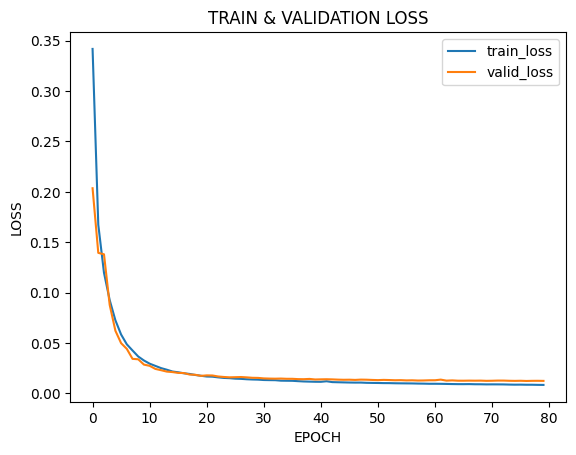

In [28]:
STATS = np.load(f'model/model.npy', allow_pickle=True).item()
plt.plot(STATS['train_loss'], label='train_loss')
plt.plot(STATS['valid_loss'], label='valid_loss')

plt.legend(loc='upper right')

plt.xlabel('EPOCH')
plt.ylabel('LOSS')

plt.title('TRAIN & VALIDATION LOSS')

Text(0.5, 1.0, 'IOU_SCORE')

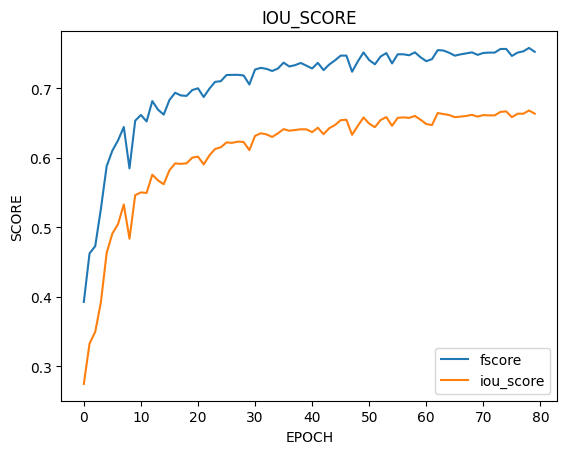

In [29]:
STATS = np.load(f'model/model.npy', allow_pickle=True).item()
plt.plot(STATS['fscore'], label ='fscore')
plt.legend(loc = "lower right")
plt.ylabel('SCORE')
plt.xlabel('EPOCH')
plt.title('F_SCORE')

plt.plot(STATS['iou_score'], label ='iou_score')
plt.legend(loc = "lower right")
plt.ylabel('SCORE')
plt.xlabel('EPOCH')
plt.title('IOU_SCORE')

In [30]:
MODEL.load_state_dict(torch.load('model/model.pth', weights_only=True))

<All keys matched successfully>

In [31]:
with torch.no_grad():
    out = MODEL(a.cuda())

Text(0.5, 1.0, 'Prediction')

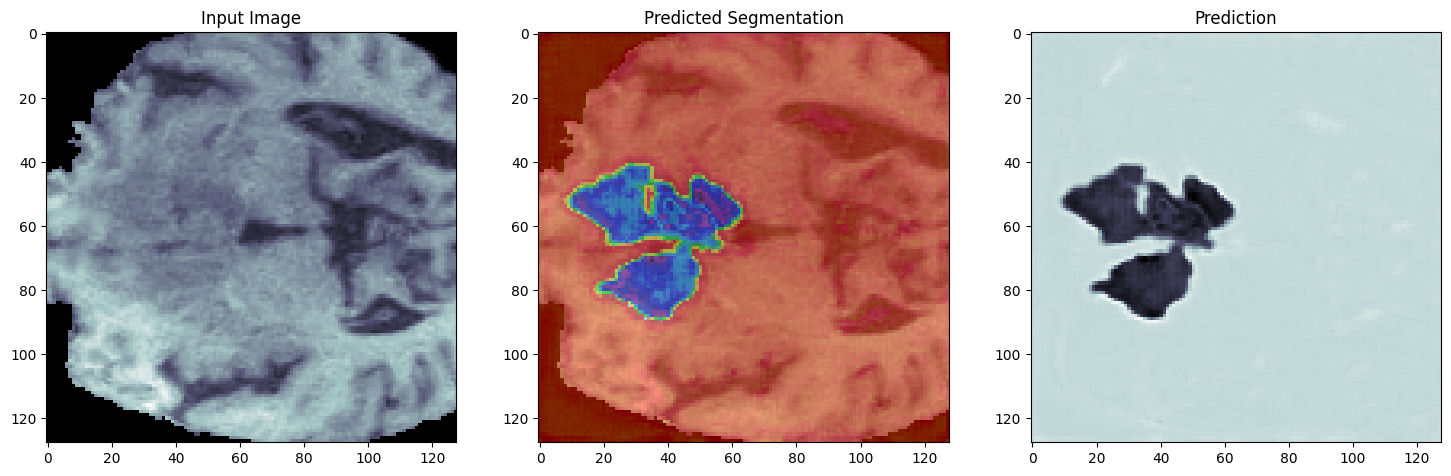

In [32]:
plt.figure(figsize = (18, 10))
plt.subplot(1, 3, 1)
plt.imshow(a[2, 0],cmap='bone')
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(a[2, 0],cmap='bone')
plt.imshow(out.cpu()[2, 0], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Predicted Segmentation')

plt.subplot(1, 3, 3)
plt.imshow(out.cpu()[2, 0], cmap = 'bone')
plt.title('Prediction')